In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools
import re
from typing import List, Tuple, Dict
import operator
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline

In [2]:
def np_equal(list1, list2):
    """Return a boolean list of whether 2 elements of the same index are equal in the two given lists"""
    return [x == y for x,y in zip(list1,list2)]

In [3]:
def any_equal(list1, value):
    """Return a boolean list of whether any elements of the given list are equal to the given value"""
    return [x == value for x in list1]

In [4]:
def mult_col_search(df: pd.DataFrame, columns: List[str], 
                    string: str, strict: bool = False) -> Tuple[List[bool], List[np.ndarray]]:
    '''Given a set of dataframe columns, which rows and columns return the substring'''
    if strict:
        col_bool = [df[col]==string for col in columns]
    else:
        col_bool = [df[col].str.contains(string) for col in columns]
    bool_mask = np.dstack(col_bool).squeeze()
    rows = [row.any() for row in bool_mask]
    cols = list(itertools.compress(columns, [c.any() for c in col_bool]))
    return rows, cols

In [5]:
def has_state(loc: str) -> bool:
    '''See if a US state name is in location string'''
    return any((state in loc) & (len(loc.split(','))<3) for state in states)
def has_uni(loc: str) -> bool:
    '''See if any college terms are in location string'''
    return any(re.match(college, loc) 
               for college in [r'(?!.*Park)(?=.*College)^(.*)$', 
                               r'.*University.*', r'.*Tech.*',
                               r'.* State'])
def has_the(loc: str) -> bool:
    '''See if the word "The" is in the beginning of the location string'''
    return re.match(r'^[tT]he .*$', loc)

In [6]:
def name_order2(list1, list2, df_index=0):
    list1 = list(enumerate(list1))
    list2 = list(enumerate(list2))
    l1_len = len(list1)
    if l1_len != len(list2):
        raise ValueError('List lengths must be equal')
    indices = [-1]*l1_len
    for i,x in list1:
        if i > 2*l1_len: raise ValueError('Caught in infinite loop')
        occurrences = sum(x in name[1] for name in list2)
        if occurrences == 0:
            raise ValueError('{} is not in list. Show number = {}'.format(x, df_index))
        elif occurrences > 1:
            list1.append((i,x))
        else:
            indices[next(j for j,n in list2 if x in n)] = i
            l2_ix = next(j for j,n in enumerate(list2) if x in n[1])
            del list2[l2_ix]
    return indices

In [7]:
def name_order(list1, list2, df_index=0):
    l1 = list1.copy()
    l2 = list(enumerate(list2))
    l1_len = len(l1)
    indices = [-1]*l1_len
    if l1_len != len(l2):
        raise ValueError('List lengths must be equal')
    for i,x in enumerate(l1):
        if i > 2*l1_len: raise ValueError('Caught in infinite loop')
        occurrences = sum(x in name[1] for name in l2)
        if occurrences == 0:
            raise ValueError('{} is not in list. Show number = {}'.format(x, df_index))
        elif occurrences > 1:
            l1.append(x)
        else:
            if i >= l1_len: i = indices.index(-1)
            indices[i] = next(j for j,n in l2 if x in n)
            l2_ix = next(j for j,n in enumerate(l2) if x in n[1])
            del l2[l2_ix]
    return indices

In [8]:
#Contestant information dataframe
contestants = pd.read_csv('contestants.txt', header=None, sep='\|\|', error_bad_lines=True,
                     names = ['show_num','date','comments','c1', 'c1_job', 'c1_loc', 'c2', 
                              'c2_job', 'c2_loc', 'c3', 'c3_job', 'c3_loc', 'c4', 'c4_job', 'c4_loc'], 
                     engine='python')

In [9]:
contestants.fillna("", inplace=True)

#Keep to only first names for easier matching
for i in range(1,5):
    #contestants['c'+str(i)] = [re.findall('^([\w"]+)?', name)[0] for name in contestants['c'+str(i)]]
    contestants['c{}_loc'.format(i)] = [loc.strip() for loc in contestants['c{}_loc'.format(i)]]

#Make super jeopardy show numbers unique
superjep_filter = contestants['comments'].str.contains('Super Jeopardy')
#contestants = contestants[~superjep_filter]
contestants.loc[superjep_filter ,'show_num'] = [i + 10000 for i in contestants.loc[superjep_filter ,'show_num']]
#Make super jeopardy show numbers unique
pilot_filter = contestants['comments'].str.contains('Trebek pilot')
contestants.loc[pilot_filter ,'show_num'] = [i + 20000 for i in contestants.loc[pilot_filter ,'show_num']]

In [10]:
#Question dataframe
reader = pd.read_csv('jeopardy_questions.txt', header=None, sep='\|\|', error_bad_lines=True,
                     names = ['season','show_num','question_num','round', 'category', 'difficulty', 
                              'question', 'answer', 'DD', 'c1', 'c1_add', 'c2', 'c2_add', 'c3', 'c3_add', 
                              'c4', 'c4_add'], 
                     engine='python', chunksize = 1000)
episodes = pd.concat([chunk for chunk in reader], ignore_index=True)

In [11]:
for i in range(1,5):
    episodes['c'+str(i)].fillna("", inplace=True)
    episodes['c{}_add'.format(i)].fillna(0, inplace=True)
    episodes['c'+str(i)] = [re.findall('^([\w" ]+)?', name)[0] for name in episodes['c'+str(i)]]
    
#Make super jeopardy show numbers unique
superjep_filter = episodes['season']=='superjeopardy'
#episodes = episodes[~superjep_filter]
episodes.loc[superjep_filter ,'show_num'] = [i + 10000 for i in episodes.loc[superjep_filter ,'show_num']]
#Make Trebek Pilot show numbers unique
pilot_filter = episodes['season']=='trebekpilots'
episodes.loc[pilot_filter ,'show_num'] = [i + 20000 for i in episodes.loc[pilot_filter ,'show_num']]

In [ ]:
episodes = episodes[(episodes['season'] != 'superjeopardy') & (episodes['season'] != 'trebekpilots')]

In [12]:
#filter for seeing if any episodes have contestants with the same first name
name_columns = ['c1', 'c2', 'c3',]
first_names = [[name.split(' ')[0] for name in 
                episodes[contestant]] for contestant in 
               name_columns]
same_names = [any(names) for names in 
              zip(*[np_equal(*name_couple) for name_couple in 
                    itertools.combinations(first_names, 2)])]

In [13]:
num_names = [[len(name.split(' ')) for name in episodes[contestant]] for contestant in name_columns]
two_name_indices = [i for contestant in num_names for i,x in enumerate(contestant) if x>1]

In [14]:
#question dataframe name corrections
qdf_name_changes = {(61, 'c2'): 'Daniel', (62, 'c2'): 'Daniel', (63, 'c1'): 'Daniel', (191, 'c2'): 'Michael',
                    (308, 'c1'): 'Paul Croshier', (690, 'c2'): 'Denny', (712, 'c3'): 'Chloe', (789, 'c1'): 'Ernest', 
                    (789, 'c2'): 'Christine', (804, 'c2'): 'David Javerbaum', (805, 'c2'): 'David Javerbaum', 
                    (829, 'c1'): 'Arthur', (834, 'c3'): 'Michael', (834, 'c2'): 'Daniel', 
                    (842, 'c1'): 'Dorothy', (1245, 'c3'): 'Steven', (1246, 'c3'): 'Steven', (1286, 'c3'): 'Mary', 
                    (1635, 'c1'): 'Vincent', (2574, 'c1'): 'Charles', (2575, 'c3'): 'Thomas', (2926, 'c1'): 'Rob', 
                    (2929, 'c1'): 'Benjamin',(3023, 'c2'): 'Jimmy', (3124, 'c2'): 'Bob', (3123, 'c2'): 'Bob', 
                    (3125, 'c2'): 'Bob', (3756, 'c3'): 'Sandra', (3757, 'c3'): 'Benjamin', (3757, 'c1'): 'Anastasia',
                    (4520, 'c3'): 'Scott', (4521, 'c1'): 'Scott', (4519, 'c2'): 'Scott', (4522, 'c2'): 'Scott',
                    (4523, 'c2'): 'Scott', (4608, 'c3'): 'Scott', (4647, 'c2'): 'Christina', (5097, 'c3'): 'Ozgun',
                    (5104, 'c2'): 'Brian', (5110, 'c2'): 'Jacob', (5716, 'c1'): 'Francois',
                    (5717, 'c1'): 'Francois', (5718, 'c2'): 'Francois', (5772, 'c2'): 'Debra', (6432, 'c2'): 'Injee',
                    (6179, 'c3'): 'Andrew', (6380, 'c2'): 'Thomas', (6934, 'c1'): 'Che', 
                    (7301, 'c2'): 'Jonathan', (7301, 'c3'): 'S.E.', (7437, 'c2'): 'Rebecca',}

In [15]:
for key in qdf_name_changes:
    episodes.loc[episodes['show_num']==key[0], key[1]] = qdf_name_changes[key]

In [16]:
for i in range(1,5):
    contestants.loc[:,'c{}_add'.format(i)] = 0

In [17]:
episodes = pd.merge(episodes,
                        contestants, 
                        on='show_num', 
                        suffixes=['_y',''])

In [18]:
df2_name_filter = ['c{}_y'.format(i) for i in range(1,4)]
df1_name_filter = ['c{}'.format(i) for i in range(1,4)]
episode_df2_slice = episodes[df2_name_filter].copy()

In [19]:
df2_correct_order = [name_order2(list(ep[df2_name_filter].values), list(ep[df1_name_filter].values), i) 
                     for i,ep in episodes.iterrows()]

In [20]:
add_columns = ['c{}_add'.format(x) for x in range(1,4)]
episodes.loc[:,add_columns] = [[episodes.loc[i,'c{}_add_y'.format(df2_i+1)] for df2_i in order] 
                               for i,order in enumerate(df2_correct_order)]
episodes.drop(['c{}_y'.format(i) for i in range(1,4)], axis=1, inplace=True)
episodes.drop(['c{}_add_y'.format(i) for i in range(1,4)], axis=1, inplace=True)

In [21]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [1110]:
'''episodes = pd.read_csv('episode_df_saved.csv', sep='¤', engine='python')
episodes.drop('Unnamed: 0', axis=1, inplace=True)'''

In [23]:
num_name_matches = [len(set(episodes.iloc[i][df2_name_filter]) & set(episodes.iloc[i][df1_name_filter])) for i,_ in enumerate(episodes)]

In [24]:
wrong_match_indices = [i for i,x in enumerate(num_name_matches) if x != 4]

In [25]:
episodes['weekday'] = [date.split(',')[0] for date in episodes['date']]

In [26]:
episodes['date'] = [date.split(',',1)[1] for date in episodes['date']]

In [28]:
episodes['date'] = pd.to_datetime(episodes['date'])
episodes['season'] = pd.to_numeric(episodes['season'])
episodes['round'] = pd.Categorical(episodes['round'], ['jeopardy_round', 'double_jeopardy_round', 'final_jeopardy_round'])

In [29]:
episodes = episodes.replace(np.nan, '', regex=True)

In [30]:
episodes.sort_values(by=['date','round', 'question_num'], inplace=True)

In [31]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 
          'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 
          'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
          'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 
          'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
          'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
          'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
          'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 
          'Wyoming']

In [32]:
state_errors = {'Missouri': ['Missiouri',], 'Virginia': ['Vriginia',], 'Kentucky': ['Kenrucky',], 
               'Illinois': ['Ilinois', 'IL',], 'Massachusetts': ['Masachusetts',], 
               'California': ['Caifornia',], 'Ohio': ['Onio',], 'New York': ['New Nork',],
               'Delaware': ['Deleware',], 'Indiana': ['Indinia',], 'Nevada': ['Nevade',],
               'Wyoming': ['Wyoming and Montana',],
               }

In [33]:
for state in state_errors:
    for error in state_errors[state]:
        episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,4)], error)] = \
        [[string.replace(error, state) for string in question]
        for question in episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) 
                                                                for i in range(1,4)], error)].values]

In [34]:
city_errors = dict(**{',{}'.format(state): state for state in states},
                   **{'New York City,New York': 'New York, New York', 
                      'New York City, New York': 'New York City',
                      'Kansas City, Missouri': 'Kansas City',
                      ', Texas': 'North Texas', 
                      ', New York': 'Trinidad and Tobago and now in New York',
                      'Easton, Maryland': 'Easton Maryland',
                      'Lynn, Massachusetts': 'Lynn Massachusetts',
                      })

In [35]:
for city in city_errors:
    episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,4)], 
                                 city_errors[city], strict=True)] = \
    [[city for string in question]
    for question in episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,4)], 
                                                 city_errors[city], strict=True)].values]

In [36]:
for i in range(1,4):
    episodes['c{}_state'.format(i)] = [loc.split(',')[1].strip() 
                                       if (has_state(loc) and not any([has_uni(loc),has_the(loc)])) 
                                       else '' if loc=='' 
                                       else 'Other'  
                                       for loc in episodes['c{}_loc'.format(i)]]

In [37]:
state_counts = dict(zip(*np.unique(episodes.groupby('show_num').first()[['c{}_state'.format(i) 
                                                                        for i in range(1,4)]], return_counts=True)))

In [38]:
unique_categories = list(zip(*np.unique(np.concatenate(list(episodes.groupby('show_num').category.unique())), return_counts=True)))

In [39]:
unique_categories.sort(key=operator.itemgetter(1), reverse=True)

In [40]:
sum(y for x,y in unique_categories[0:100])

8869

In [46]:
episodes[episodes['category']=='SCIENCE'].shape

(851, 32)

In [43]:
unique_categories[0:100]

[('SCIENCE', 183),
 ('AMERICAN HISTORY', 170),
 ('LITERATURE', 170),
 ('WORD ORIGINS', 167),
 ('SPORTS', 150),
 ('BUSINESS & INDUSTRY', 147),
 ('WORLD GEOGRAPHY', 143),
 ('POTPOURRI', 141),
 ('U.S. CITIES', 137),
 ('STATE CAPITALS', 136),
 ('BEFORE & AFTER', 135),
 ('WORLD HISTORY', 133),
 ('AUTHORS', 131),
 ('HISTORY', 131),
 ('WORLD CAPITALS', 124),
 ('TRANSPORTATION', 122),
 ('ISLANDS', 119),
 ('RELIGION', 118),
 ('COLLEGES & UNIVERSITIES', 116),
 ('ART', 115),
 ('ANIMALS', 113),
 ('U.S. HISTORY', 112),
 ('U.S. PRESIDENTS', 112),
 ('THE BIBLE', 109),
 ('BODIES OF WATER', 107),
 ('U.S. GEOGRAPHY', 107),
 ('OPERA', 104),
 ('SHAKESPEARE', 103),
 ('LANGUAGES', 100),
 ('CLASSICAL MUSIC', 99),
 ('TELEVISION', 99),
 ('AMERICANA', 96),
 ('BOOKS & AUTHORS', 94),
 ('FOOD', 94),
 ('FICTIONAL CHARACTERS', 93),
 ('MYTHOLOGY', 91),
 ('BALLET', 90),
 ('PEOPLE', 90),
 ('AMERICAN LITERATURE', 89),
 ('GEOGRAPHY', 88),
 ('THE CIVIL WAR', 85),
 ('HISTORIC NAMES', 84),
 ('MUSEUMS', 83),
 ('RHYME TIME', 

In [1147]:
#episodes.set_index(['season', 'show_num', 'round'], inplace=True)
#episodes.sort_index(inplace=True)

In [1153]:
#episodes.reset_index(inplace=True)

In [522]:
#episodes.drop(labels = ['winner', 'winner_locs', 'winner_winnings'], axis=1, inplace=True)

In [48]:
for i in range(1,5):
    episodes['c{}_cumsum'.format(i)] = episodes.groupby('show_num')['c{}_add'.format(i)].transform(pd.Series.cumsum)

In [49]:
winner = episodes.groupby('show_num').last()[['c1_cumsum','c2_cumsum', 'c3_cumsum']].idxmax(axis=1)

In [50]:
winner = pd.DataFrame([[i, x[:2]] for i,x in zip(winner.index, winner)], columns = ['show_num', 'winner'])

In [51]:
winner_winnings = episodes.groupby('show_num').last()[['c1_cumsum','c2_cumsum', 'c3_cumsum']].max(axis=1)

In [52]:
winner_winnings = pd.DataFrame([[i, x] 
                                for i,x in zip(winner_winnings.index, winner_winnings)], 
                               columns = ['show_num', 'winner_winnings'])

In [53]:
episodes = pd.merge(episodes,
                    winner, 
                    on='show_num', 
                    suffixes=['','_y'])

In [54]:
episodes = pd.merge(episodes,
                    winner_winnings, 
                    on='show_num', 
                    suffixes=['','_y'])

In [55]:
winner_locs = [episodes[contestant+'_loc'].iloc[i]
                 for i, contestant in enumerate(episodes['winner'])]

In [56]:
episodes['winner_loc'] = winner_locs

In [57]:
winner_states = [episodes[contestant+'_state'].iloc[i]
                 for i, contestant in enumerate(episodes['winner'])]

In [58]:
episodes['winner_state'] = winner_states

In [59]:
winner_state_counts = dict(zip(*np.unique(episodes.groupby('show_num').first()['winner_state'], return_counts=True)))

In [61]:
state_win_percentage = {state: math.floor(winner_state_counts[state]/state_counts[state]*100)/100 for state in state_counts}

In [62]:
state_winnings = episodes.groupby('show_num')[['winner_state','winner_winnings']].first().groupby('winner_state').mean().to_dict()['winner_winnings']

In [63]:
state_mean_winnings = {state: math.floor(state_winnings[state]*state_win_percentage[state]) for state in state_winnings}

In [64]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [65]:
episodes = episodes.ix[:,['season', 'show_num', 'date', 'weekday',
                          'comments', 'question_num','round',
                          'category', 'difficulty', 'question', 'answer', 'DD', 
                          'c1', 'c1_add', 'c1_cumsum', 'c1_job', 'c1_loc', 'c1_state',
                          'c2', 'c2_add', 'c2_cumsum', 'c2_job', 'c2_loc', 'c2_state',
                          'c3', 'c3_add', 'c3_cumsum', 'c3_job', 'c3_loc', 'c3_state',
                          'winner', 'winner_loc', 'winner_state', 'winner_winnings']]

In [393]:
unique_jobs = list(zip(*np.unique([x.replace(', ', ',') 
                                   for x in 
                                   episodes.groupby('show_num')[['c1_job', 'c2_job',
                                                                 'c3_job', 'c4_job']].first().values.ravel('K')], 
                                  return_counts=True)))

In [394]:
unique_jobs.sort(key=operator.itemgetter(1), reverse=True)

In [395]:
job_types = {('education_job', 1): ['student', 'teacher', 'professor', 'phd', 'ph.d.', 'freshman', 'junior$', 
                                  'sophomore', 'senior$', 'librarian', 'university', 'college', 'tutor', 'educat'],
             ('management_job', 2): ['manag', 'executive', 'director', 'producer', 'owner', 'president', 'supervisor'],
             ('legal_job', 3): ['law', 'legal', 'attorney', 'prosecut', 'litigat', 'legislat', 'defender'],
             ('analyst_job', 4): ['analyst', 'underwriter', 'actuary', 'supply chain', 'accountant', 
                                'consultant', 'econom', 'data'],
             ('writing_job', 5): [r'(?<!under)writer', 'author', 'editor', 'journalist', 'newspaper', 'novel'],
             ('computer_job', 6): ['software', 'web', 'network', r'^it ', r'^i.t.', 'computer', 'programmer'],
             ('medical_job', 7): ['physician', 'doctor', 'pharmac', 'nurse', 'veterin', 'pediat',
                                  'psychiatr', 'psycholog', 'medic', 'health', 'cardiol',
                                  'dietician', 'surge'],
             ('homemaker', 8): ['homemaker', 'stay-at-home', 'housewife'],
             ('kid', 9): ['year-old', 'grader'],
             ('service_job',10): ['assistant', 'bartender', 'bookseller', 'social work', 'waiter', 'waitress',
                                  'secretary', 'sales', 'service', 'attend'],
             ('science_job', 11): ['research', 'scien', 'astronomer', r'(?<!psycho)logist', 'engineer'],
             ('creative_job', 12): ['chef', 'act', 'composer', 'graphic', 'design', 'art', 'culinary', 
                                     'music', 'architect',],
             ('government_job', 13): ['firefighter', 'officer', 'letter carrier', 'mail', 'government'],
             ('religious_job', 14): ['pastor', r'^minist', ' minist', 'priest',],
             ('real_estate', 15): ['realt', 'real estate']
             }

In [468]:
def assign_job_category(jobs: List[Tuple[str, int]], job_cats: Dict[str, List[str]]) -> Dict[str, str]:
    '''Given a dict with job category key words and relevant substring list values, match each unique job
    to a category'''
    jobs = jobs.copy()
    job_dict = {}
    for key in sorted(list(job_cats.keys()),key=lambda x: x[1]):
        job_match = [any(re.search(word, j[0].lower()) for word in job_cats[key]) for j in jobs]
        job_dict.update({j[0]: key[0] for i,j in enumerate(jobs) if job_match[i]})
        jobs = [j for i,j in enumerate(jobs) if not job_match[i]]
    job_dict.update({j[0]: 'Other' for j in jobs if j[0] != ''})
    job_dict.update({j[0]: '' for j in jobs if j[0] == ''})
    return job_dict

In [469]:
job_cat_dict = assign_job_category(unique_jobs, job_types)

In [470]:
for i in range(1,4):
    episodes['c{}_job_category'.format(i)] = [job_cat_dict[job.replace(', ', ',')] for job in episodes['c{}_job'.format(i)]]

In [471]:
for i in range(1,4):
    episodes['c{}_answer'.format(i)] = ['right' if value>0 else 'wrong' if value<0 else 'neither' 
                                        for value in episodes['c{}_add'.format(i)]]

In [472]:
episodes['winner_job_category'] = [episodes.loc[i,winner+'_job_category'] for i, winner in enumerate(episodes['winner'])]

In [501]:
job_category_win_counts = episodes['show_num'].groupby(episodes['show_num']).first()\
.groupby(episodes['winner_job_category']).count().reset_index(name='count')

In [512]:
job_category_win_counts

,winner_job_category,count
0,,163
1,Other,705
2,analyst_job,404
3,creative_job,652
4,education_job,1455
5,government_job,181
6,homemaker,164
7,legal_job,525
8,management_job,548
9,medical_job,180


In [504]:
job_category_counts = pd.DataFrame(list(zip(*np.unique(episodes[['c{}_job_category'.format(i) 
                                                    for i in range(1,4)]].groupby(episodes['show_num']).first().values.ravel('K'),
                                          return_counts=True))), columns = ('job_category', 'count'))

In [525]:
episodes[(episodes['c3_job'].str.contains('act')) & ((episodes['c1_job'].str.contains('act')) | (episodes['c2_job'].str.contains('act')))].groupby('show_num').first().shape

(42, 48)

In [526]:
job_cat_counts = pd.merge(job_category_counts, job_category_win_counts, left_on='job_category', right_on='winner_job_category',
        suffixes=['', '_win']).drop('winner_job_category', axis=1)

In [530]:
job_cat_counts['percentage'] = job_cat_counts.count_win/job_cat_counts['count']

In [637]:
#Calculations to get how many right/wrong/neither answers each contestant had per show
contestant_num_right = pd.melt(episodes[['show_num'] + ['c{}_answer'.format(i) for i in range(1,4)]], id_vars='show_num', var_name='contestant',
       value_name='answer').reset_index().groupby(['show_num', 'contestant', 'answer']).count()

In [638]:
contestant_percent_right = contestant_num_right.groupby(level=[0,1]).apply(lambda x: x / x.sum()).unstack().unstack()

In [639]:
contestant_percent_right.columns = [col[2].split('_')[0] + '_' + col[1] 
                                    for col in contestant_percent_right.columns.values]

In [640]:
contestant_percent_right = contestant_percent_right.reset_index()

In [644]:
episodes = pd.merge(episodes,
                    contestant_percent_right, 
                    on='show_num', 
                    suffixes=['','_y'])

In [661]:
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]] = \
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]].replace('', np.nan, regex=True)
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]] = \
episodes.loc[:,['c{}_neither'.format(i) for i in range(1,4)] + \
         ['c{}_right'.format(i) for i in range(1,4)] + \
         ['c{}_wrong'.format(i) for i in range(1,4)]].fillna(0)

In [ ]:
#This next section is focusing on me actually just working with a stacked dataframe instead of trying to finagle
#my way around the wide dataframe with c1,c2,c3 etc. My fears of a triply long dataframe have been overcome by my
#annoyance over this issue

In [688]:
prestack = episodes.copy().groupby('show_num')[[x for x in episodes.columns if re.search(r'c\d', x)]].first()

In [36]:
values = [('name', ['c{}'.format(i) for i in range(1,4)]),
          ('add', ['c{}_add'.format(i) for i in range(1,4)]),
          ('cumsum', ['c{}_cumsum'.format(i) for i in range(1,4)]),
          ('job', ['c{}_job'.format(i) for i in range(1,4)]),
          ('loc', ['c{}_loc'.format(i) for i in range(1,4)]),
          ('state', ['c{}_state'.format(i) for i in range(1,4)]),
          ('job_category', ['c{}_job_category'.format(i) for i in range(1,4)]),
          ('answered', ['c{}_answer'.format(i) for i in range(1,4)]),
          ('percent_right', ['c{}_right'.format(i) for i in range(1,4)]),
          ('percent_wrong', ['c{}_wrong'.format(i) for i in range(1,4)]),
          ('percent_neither', ['c{}_neither'.format(i) for i in range(1,4)])]

In [704]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [8]:
episodes = pd.read_csv('episode_df_saved.csv', sep='¤', engine='python')
episodes.drop('Unnamed: 0', axis=1, inplace=True)

In [39]:
episodes = episodes.ix[:,['season', 'show_num', 'date', 'weekday',
                          'comments', 'question_num','round',
                          'category', 'difficulty', 'question', 'answer', 'DD', 
                          'c1', 'c1_add', 'c1_cumsum', 'c1_job', 'c1_loc', 'c1_state', 
                          'c1_job_category', 'c1_answer', 'c1_neither', 'c1_right', 'c1_wrong',
                          'c2', 'c2_add', 'c2_cumsum', 'c2_job', 'c2_loc', 'c2_state',
                          'c2_job_category', 'c2_answer', 'c2_neither', 'c2_right', 'c2_wrong',
                          'c3', 'c3_add', 'c3_cumsum', 'c3_job', 'c3_loc', 'c3_state',
                          'c3_job_category', 'c3_answer', 'c3_neither', 'c3_right', 'c3_wrong',
                          'winner', 'winner_loc', 'winner_state', 'winner_winnings']]

In [58]:
melted_dataframes = [pd.melt(episodes.copy(), 
                id_vars=[x for x in episodes.columns if not re.search(r'c\d', x)], 
                value_vars=val[1], var_name='contestant', 
                value_name=val[0]) for val in values]

In [59]:
for df in melted_dataframes:
    df['contestant'] = df.contestant.str.slice(0,2)

In [60]:
stacked_eps = reduce(lambda left,right: pd.merge(left,right,on=['contestant'] + \
                                                 [x for x in episodes.columns 
                                                  if not re.search(r'c\d', x)]), melted_dataframes)

In [74]:
stacked_eps['percent_attempted_correct'] = \
stacked_eps['percent_right'] / (stacked_eps['percent_right'] + stacked_eps['percent_wrong'])

In [139]:
fj_diffs = stacked_eps.groupby(['show_num', 'contestant']).nth(-1)['add']

In [140]:
before_fj_score = stacked_eps.groupby(['show_num', 'contestant']).nth(-2)['cumsum']

In [155]:
stacked_eps.drop('fj_wager_percentage', axis=1, inplace=True)

In [156]:
stacked_eps = pd.merge(stacked_eps, 
                       pd.DataFrame(abs(fj_diffs/before_fj_score), 
                                    columns=['fj_wager_percentage']).reset_index().replace(np.inf, 0).replace(-np.inf,0), 
                       on=['show_num', 'contestant'])

In [259]:
stacked_eps['DD1'] = False #Round 1 Daily Double
stacked_eps['DD2'] = False #Double Jeopardy First Daily Double
stacked_eps['DD3'] = False #Double Jeopardy Second Daily Double

In [260]:
stacked_eps.loc[(stacked_eps['DD']) & \
            (stacked_eps['answered']!='neither') & \
            (stacked_eps['round']=='jeopardy_round'),'DD1'] = True

In [261]:
DD2 = stacked_eps.copy()[(stacked_eps['DD']) & \
            (stacked_eps['answered']!='neither') & \
            (stacked_eps['round']=='double_jeopardy_round')]\
.sort_values(by=['show_num', 'question_num']).groupby('show_num', as_index=False, sort=False)\
[['question_num','contestant']].first()

In [262]:
DD2_index = DD2.set_index(['show_num', 'question_num', 'contestant']).index
whole_index = stacked_eps.set_index(['show_num', 'question_num', 'contestant']).index

In [263]:
stacked_eps.loc[whole_index.isin(DD2_index),'DD2'] = True

In [264]:
DD3 = stacked_eps.copy()[(stacked_eps['DD']) & \
            (stacked_eps['answered']!='neither') & \
            (stacked_eps['round']=='double_jeopardy_round')]\
.sort_values(by=['show_num', 'question_num']).groupby('show_num', as_index=False, sort=False)\
[['question_num','contestant']].last()

In [265]:
DD3_index = DD3.set_index(['show_num', 'question_num', 'contestant']).index

In [267]:
stacked_eps.loc[(whole_index.isin(DD3_index)) & (~whole_index.isin(DD2_index)), 'DD3'] = True

In [268]:
stacked_eps.head()

,season,show_num,date,weekday,comments,question_num,round,category,difficulty,question,...,job_category,answered,percent_right,percent_wrong,percent_neither,percent_attempted_correct,fj_wager_percentage,DD1,DD2,DD3
0,1,1,1984-09-10,Monday,Premiere episode with Alex Trebek as host.,1,jeopardy_round,ANIMALS,1,These rodents first got to America by stowing ...,...,writing_job,neither,0.354167,0.145833,0.5,0.708333,1.0,False,False,False
1,1,1,1984-09-10,Monday,Premiere episode with Alex Trebek as host.,2,jeopardy_round,ANIMALS,2,"There are about 40,000 muscles & tendons in th...",...,writing_job,right,0.354167,0.145833,0.5,0.708333,1.0,False,False,False
2,1,1,1984-09-10,Monday,Premiere episode with Alex Trebek as host.,3,jeopardy_round,ACTORS & ROLES,1,Video in which Michael Jackson plays a werewol...,...,writing_job,right,0.354167,0.145833,0.5,0.708333,1.0,False,False,False
3,1,1,1984-09-10,Monday,Premiere episode with Alex Trebek as host.,4,jeopardy_round,ACTORS & ROLES,2,"2 ""Saturday Night"" alumni who tried ""Trading P...",...,writing_job,right,0.354167,0.145833,0.5,0.708333,1.0,False,False,False
4,1,1,1984-09-10,Monday,Premiere episode with Alex Trebek as host.,5,jeopardy_round,ACTORS & ROLES,3,"He may ""Never Say Never Again"" when asked to b...",...,writing_job,right,0.354167,0.145833,0.5,0.708333,1.0,False,False,False


In [162]:
mean_state_values = stacked_eps.groupby(['show_num', 'contestant'], as_index=False).first().groupby('state').mean()

In [163]:
mean_job_values = stacked_eps.groupby(['show_num', 'contestant'], as_index=False).first().groupby('job_category').mean()

In [165]:
mean_state_values.sort_values(by='fj_wager_percentage')

,show_num,season,question_num,DD,winner_winnings,add,cumsum,percent_right,percent_wrong,percent_neither,percent_attempted_correct,fj_wager_percentage
state,,,,,,,,,,,,
Utah,4979.206612,22.173554,1.0,0.000000,27787.685950,113.223140,113.223140,0.477568,0.056365,0.466067,0.884004,0.363936
North Dakota,3659.000000,16.250000,1.0,0.000000,14124.750000,150.000000,150.000000,0.401639,0.053279,0.545082,0.887296,0.482382
West Virginia,4686.360000,20.820000,1.0,0.000000,15953.160000,76.000000,76.000000,0.295432,0.053624,0.650944,0.836818,0.483213
Delaware,5351.975000,23.900000,1.0,0.000000,20212.687500,76.250000,76.250000,0.320927,0.050264,0.628809,0.857463,0.490452
Idaho,5649.333333,25.090909,1.0,0.000000,22019.787879,75.757576,75.757576,0.303912,0.047143,0.648946,0.856406,0.527724
Michigan,4747.446927,21.192737,1.0,0.000000,16474.885475,48.603352,48.603352,0.290207,0.053756,0.656038,0.838105,0.535444
Vermont,5189.426230,23.114754,1.0,0.016393,19907.754098,62.295082,62.295082,0.286443,0.052507,0.661050,0.834636,0.549022
Kentucky,5077.169154,22.592040,1.0,0.009950,19453.890547,55.721393,55.721393,0.298414,0.056382,0.645204,0.831749,0.550907
South Carolina,4894.000000,21.810458,1.0,0.006536,16481.235294,64.705882,64.705882,0.277632,0.053414,0.668954,0.830106,0.551622


In [86]:
mean_state_values.sort_values(by='percent_attempted_correct')

,show_num,season,question_num,DD,winner_winnings,add,cumsum,percent_right,percent_wrong,percent_neither,percent_attempted_correct
state,,,,,,,,,,,
Hawaii,4275.860000,19.060000,1.0,0.000000,18163.020000,22.000000,22.000000,0.239624,0.060010,0.700366,0.791646
Wyoming,4741.071429,20.928571,1.0,0.000000,19728.714286,64.285714,64.285714,0.238004,0.058337,0.703659,0.794137
Rhode Island,4586.924242,20.484848,1.0,0.015152,17686.560606,48.484848,48.484848,0.264044,0.061401,0.674555,0.802296
New Mexico,4698.640000,20.920000,1.0,0.000000,17170.380000,38.000000,38.000000,0.259854,0.060107,0.680039,0.807979
Alabama,5076.248000,22.616000,1.0,0.000000,16799.808000,84.800000,84.800000,0.278449,0.064021,0.657530,0.810383
Nevada,4420.757143,19.685714,1.0,0.000000,18346.571429,34.285714,34.285714,0.268372,0.057598,0.674030,0.815687
Maine,4493.877193,20.105263,1.0,0.000000,17393.052632,38.596491,38.596491,0.261910,0.055024,0.683066,0.817560
Wisconsin,4735.228070,21.122807,1.0,0.000000,16818.760234,42.690058,42.690058,0.276011,0.058184,0.665804,0.819236
North Carolina,5239.417544,23.350877,1.0,0.003509,17921.950877,55.789474,55.789474,0.271639,0.054107,0.674254,0.820952


In [430]:
episodes.loc[(episodes['c1_answer']=='wrong') & (episodes['c2_answer']=='wrong') \
         & (episodes['c3_answer']=='wrong') & (episodes['round']=='jeopardy_round')\
        & (episodes['difficulty']==1), ['question','answer']]

,question,answer
42058,Paul Revere & William Dawes warn colonists tha...,the 1770s
64740,"A former Socialist, he formed the anti-Communi...",Benito Mussolini
73841,"After an 1891 roulette run, Charles Wells was ...",Monte Carlo
83328,It was the last decade in which Cher didn't ha...,1950s
86757,"Dewaele won the Tour de France, Coco Chanel wa...",1929
102595,"According to tradition, Dismas & Gestas were t...",Calvary
107226,Sink it & you've scratched,the cue ball
122303,"The combo that totals one shy of ""boxcars""",5 & 6
145216,Monthly fees to groups of physicians for miner...,Blue Shield
147989,"America's second-largest daily newspaper, it's...",The Wall Street Journal


In [68]:
unique_locs = list(zip(*np.unique([x.replace(', ', ',') 
                                   for x in 
                                   episodes.groupby('show_num')[['c1_loc', 'c2_loc',
                                                                 'c3_loc', 'c4_loc']].first().values.ravel('K')], 
                                  return_counts=True)))

In [69]:
unique_locs.sort(key=operator.itemgetter(1), reverse=True)

In [75]:
state_locs = list(itertools.compress(list(zip(*unique_locs))[0],
                                     [state and not uni and not the 
                                      for state, uni, the in zip(has_state,has_uni, has_the)]))

In [77]:
scores_by_season = episodes.groupby('show_num').last().set_index('season')[['c{}_cumsum'.format(i) for i in range(1,4)]]
mean_scores_by_season = scores_by_season.stack().groupby(level=0).mean().values
score_se_by_season = scores_by_season.stack().groupby(level=0).apply(sem).values

In [78]:
plt.figure(figsize=(12,9))

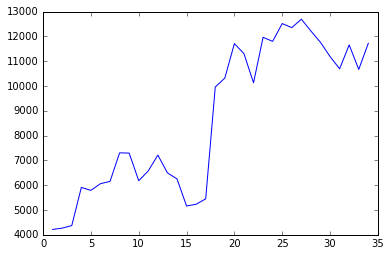

In [79]:
plt.plot(episodes.season.unique(), mean_scores_by_season);

In [1198]:
aggregations = {
    'stumper': lambda x: sum(x>0)
}

In [1219]:
#Working on seeing how many questions are answered wrong/right per contestant
stumpers = episodes.set_index(['season', 'show_num', 'question_num'])[['c{}_add'.format(i) for i in range(1,5)]].stack().groupby(level=[0,1,2]).agg(aggregations)

In [1221]:
stumpers2 = stumpers.groupby(level=[0,1])['stumper'].agg({'stumpers': lambda x: sum(x==0)/x.count()})

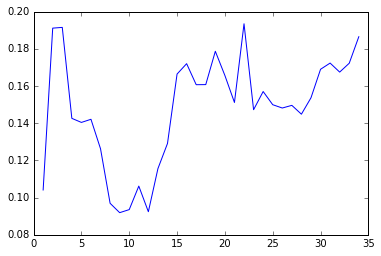

In [1225]:
plt.plot(stumpers2.groupby(level=0)['stumpers'].mean().index,stumpers2.groupby(level=0)['stumpers'].mean().values)

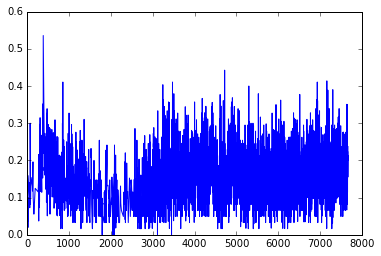

In [1214]:
plt.plot(stumpers2.index, stumpers2.values)

In [1217]:
[x for x,y in zip(stumpers2.index, stumpers2.values) if y > 0.5]

[383]